In [1]:
# Math libraries
import numpy as np
import scipy.optimize as opt

# For opening netcdf files
import xarray as xr

# Plotting libraries
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Universal plotting styling
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.family'] = 'serif'
%config InlineBackend.figure_format='retina'

In [2]:
# Opening trended anomaly dataset
dataset = xr.open_dataset('./processed_data/trended_anomaly.nc')
dataset = dataset.isel(zlev=0)

In [3]:
dataset

<xarray.Dataset> Size: 153MB
Dimensions:  (time: 15336, lat: 24, lon: 104)
Coordinates:
  * time     (time) datetime64[ns] 123kB 1982-01-03T12:00:00 ... 2023-12-29T1...
  * lat      (lat) float64 192B -30.0 -27.5 -25.0 -22.5 ... 20.0 22.5 25.0 27.5
  * lon      (lon) float64 832B 30.0 32.5 35.0 37.5 ... 280.0 282.5 285.0 287.5
Data variables:
    anom     (time, lat, lon) float32 153MB ...

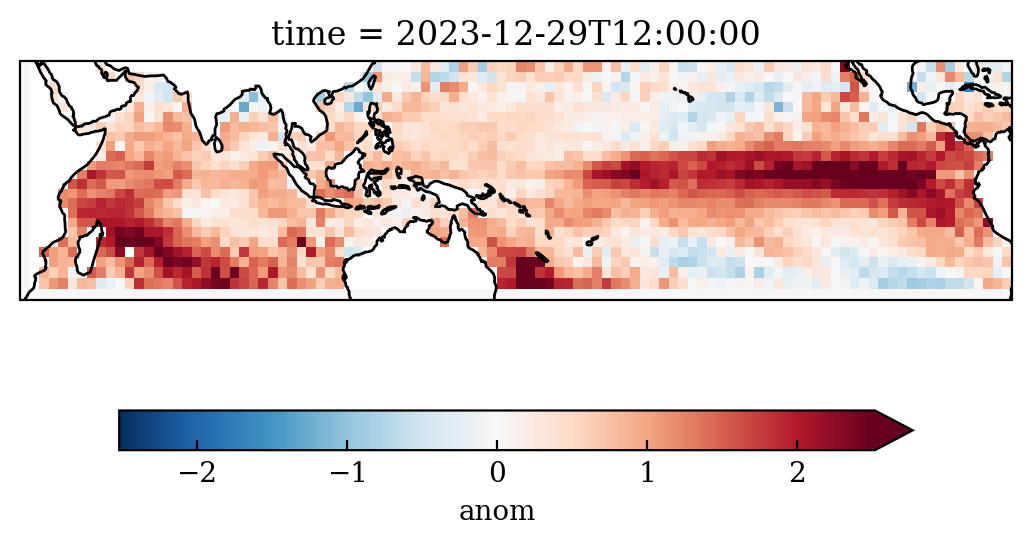

In [4]:
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Mercator(central_longitude=160, min_latitude=-45, max_latitude=45)))

dataset['anom'].isel(time=-1).plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),  # this is important!
    # usual xarray stuff
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.8},
    robust=True,
)
ax.coastlines();

In [5]:
# Averaging the entirety of our basin
basin_mean = dataset.mean(dim=['lat', 'lon'], skipna=True)

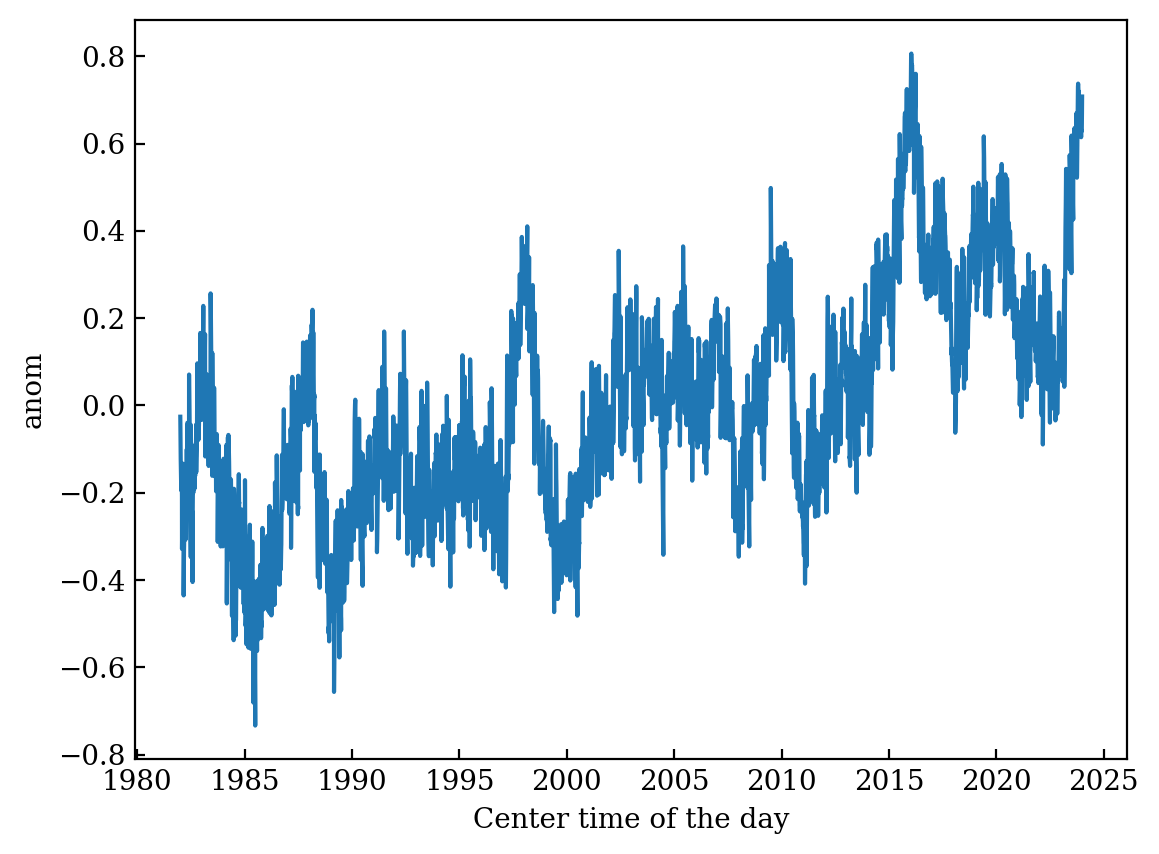

In [6]:
basin_mean['anom'].plot()

In [7]:
# x is an array like
# *args are the coefficents for the polynomial
# poly_func(x, a, b, c) returns a quadratic polynomial a + bx + cx**2
def poly_func(x, *args):
    # Array to store result
    res = np.zeros_like(x)
    # The ith element in *args is the ith coefficient for x**i!
    for i in range(len(args)):
        # Add current polynomial term
        res += args[i] * x**i
    # Return result
    return res

# Times from dataset
dataset_dates = np.array(basin_mean['time'])
# Casting times to days since January 1, 1982
time = np.arange(0, len(dataset_dates), 1, dtype=float) + 3
# Basin mean data
mean_anoms = np.array(basin_mean['anom'])

# Fitting a quadratic to basin mean anomaly
popt, pcov = opt.curve_fit(lambda x, a, b, c: poly_func(x, a, b, c), time, mean_anoms)
# Calculating parameter error
perr = np.sqrt(np.diag(pcov))

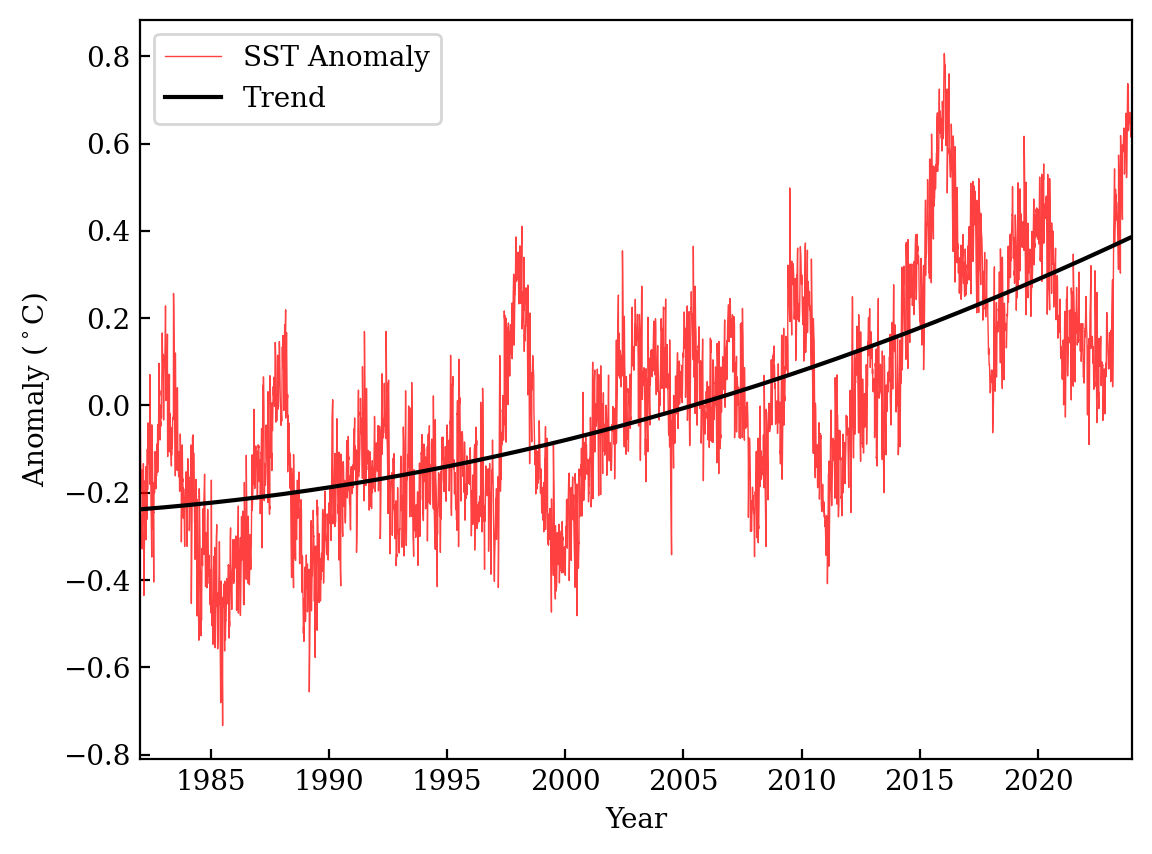

In [8]:
# Plotting data with trend
fig, ax = plt.subplots(1, 1)

# Setting x and y labels
ax.set_xlabel('Year')
ax.set_ylabel(r'Anomaly ($^\circ$C)')

# Setting x limit
ax.set_xlim([dataset_dates[0], dataset_dates[-1]])

# Plotting data
ax.plot(dataset_dates, mean_anoms, c='red', alpha=0.75, lw=0.5, label='SST Anomaly')
# Plotting fit
ax.plot(dataset_dates, poly_func(time, *popt), c='k', lw=1.5, label='Trend')
# Plotting fit error
# ax.fill_between(dataset_dates, poly_func(time, *(popt + perr)), poly_func(time, *(popt - perr)), color='gray', alpha=0.5)
# Plotting horizontal line at 0
# ax.hlines(0, dataset_dates[0], dataset_dates[-1], color='gray')

# Legend
ax.legend(loc='best');